## Постановка задачи

На первой практике вам предстоит поработать с реальными данными об истории экспертиз рабочих программ дисциплин в ИТМО.

**Задача:** сделать краткое исследование данных и построить 3 графика двумя способами. Первый способ - самостоятельно. Второй - с активной помощью ChatGPT, Perplexity или [любого другого ИИ](https://theresanaiforthat.com/). Порядок реализации способов значения не имеет. Библиотеки можно использовать любые.

**Цель:** оценить качество помощи ИИ для аналитики. В конце обязательно сделайте текстовый вывод по результатам работы!

## Загрузка данных

Загрузим датасет в колаб, найти его также можно [по ссылке](https://drive.google.com/file/d/1mJoAbyxf7vUU8_bVQvsahdW3HY8uz-V8/view?usp=share_link), если по какой-то причине у вас не работает gdown.

In [265]:
import pandas as pd
import numpy as np
import seaborn as sns

!gdown 1mJoAbyxf7vUU8_bVQvsahdW3HY8uz-V8

Downloading...
From: https://drive.google.com/uc?id=1mJoAbyxf7vUU8_bVQvsahdW3HY8uz-V8
To: /content/exp_stats.csv
100% 925k/925k [00:00<00:00, 60.9MB/s]


Посмотрим на данные.

In [266]:
data = pd.read_csv("/content/exp_stats.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7657 entries, 0 to 7656
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   workprogram_id     7657 non-null   int64 
 1   user_count         7657 non-null   int64 
 2   expertise_status   7657 non-null   object
 3   expertise_counter  7657 non-null   int64 
 4   approval_date_y    7657 non-null   object
 5   title              7657 non-null   object
dtypes: int64(3), object(3)
memory usage: 359.0+ KB


Всего шесть столбцов, все без пропусков:
- `workprogram_id` - айди рабочей программы (РПД)
- `user_count` - сколько человек принимали участие в создании РПД
- `expertise_status` - на каком этапе экспертизы находится РПД (статус экспертизы: AC - одобрена, RE - на доработке, AR - в архиве, EX - на экспертизе, WK - в работе)
- `expertise_counter` - сколько раз РПД проходила экспертизу
- `approval_date` - день, когда РПД признали удовлетворяющей всем требованиям и разрешили ее реализовывать
- `title` - название дисциплины


In [267]:
data.head()

,workprogram_id,user_count,expertise_status,expertise_counter,approval_date_y,title
0,2626,4,AC,1,2022-05-06 14:23:17.924 +0200,Философия
1,8461,4,AC,1,2022-04-28 09:01:59.171 +0200,Философия
2,2627,3,AC,5,2021-08-31 20:51:19.142 +0200,Введение в цифровую культуру и программирование
3,2628,4,AC,0,2022-04-28 11:36:30.474 +0200,Проектирование баз данных
4,2631,4,AC,0,2022-04-28 12:06:31.165 +0200,Современные вопросы информатики


## Краткое исследование данных

В данных не слишком много столбцов и уже известно, что нет пустых ячеек. Теперь неплохо было бы погрузиться в них и ответить на 3 небольших вопроса:
1. Какой период охватывают данные в датасете?
2. Есть ли в данных нетипичные значения? Например, неположительные числа в столбце `user_count`. Или даты, которые сильно выбиваются из общего диапазона значений.
3. Есть ли нелогичные значения в данных? Например, статус РПД "в работе", но есть `approval_date`. Или статус "одоберно", но РПД 0 раз проходила экспертизу.



### Вопрос 1. Какой период охватывают данные в датасете?

In [268]:
data['approval_date_y'] = pd.to_datetime(data['approval_date_y'])
print(f"Минимальная дата:\t{data['approval_date_y'].min()}")
print(f"Максимальная дата:\t{data['approval_date_y'].max()}")

Минимальная дата:	2021-04-21 11:32:30.614000+02:00
Максимальная дата:	2023-04-17 11:35:20.872000+02:00


<ipython-input-268-e53f1936c9e9>:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['approval_date_y'] = pd.to_datetime(data['approval_date_y'])


### Вопрос 2. Есть ли в данных нетипичные значения? Например, неположительные числа в столбце user_count. Или даты, которые сильно выбиваются из общего диапазона значений.

In [269]:
negative_user_count = data[data['user_count'] <= 0]

if negative_user_count.empty:
    print("Неположительных user_count нет")
else:
    print("Неположительные user_count:")
    print(negative_user_count[['workprogram_id', 'user_count']])

Неположительных user_count нет


In [270]:
data = data.sort_values(by='approval_date_y')

low = data['approval_date_y'].quantile(0.25)
high = data['approval_date_y'].quantile(0.75)
iqr = high - low
lower_bound = low - 1.5 * iqr
upper_bound = high + 1.5 * iqr # данные за этими границами считаются выбросами

inliers = data['approval_date_y'].between(lower_bound, upper_bound)
outliers = data[~inliers]

if not outliers.empty:
    min_outlier = outliers['approval_date_y'].min()
    max_outlier = outliers['approval_date_y'].max()
    count_outliers = len(outliers)
    print(f"Выбивающиеся даты: \nот {min_outlier} \nдо {max_outlier} \nВсего {count_outliers} выбивающихся дат.")
else:
    print("Выбивающихся дат нет")

#print("Выбивающиеся даты:")
#print(outliers[['workprogram_id', 'approval_date_y']])


Выбивающиеся даты: 
от 2021-04-21 11:32:30.614000+02:00 
до 2021-07-15 16:45:26.924000+02:00 
Всего 608 выбивающихся дат.


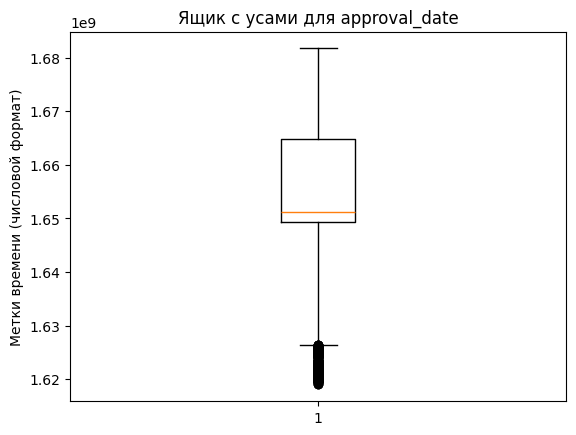

In [271]:
import pandas as pd
import matplotlib.pyplot as plt

plt.boxplot(data['approval_date_y'].apply(lambda x: int(x.timestamp())))

plt.title("Ящик с усами для approval_date")
plt.ylabel("Метки времени (числовой формат)")
plt.show()


### Вопрос 3. Есть ли нелогичные значения в данных? Например, статус РПД "в работе", но есть approval_date. Или статус "одоберно", но РПД 0 раз проходила экспертизу.

In [272]:
wk_with_approval = data[(data['expertise_status'] == 'WK') & (data['approval_date_y'].notna())]
print("Статус 'в работе' при наличии approval_date:")
print(wk_with_approval[['workprogram_id', 'approval_date_y']])

Статус 'в работе' при наличии approval_date:
      workprogram_id                   approval_date_y
2618           10886  2021-05-17 17:54:10.233000+02:00
5094           17710  2022-05-01 17:21:12.293000+02:00
5093           17709  2022-05-01 17:38:54.897000+02:00
5095           17711  2022-05-01 18:09:25.089000+02:00


In [273]:
ac_with_no_expertise = data[(data['expertise_status'] == 'AC') & (data['expertise_counter'] == 0)]
print(f"Статус 'одобрено' при нулевом expertise_counter имеют {len(ac_with_no_expertise)} РПД.")
print(ac_with_no_expertise[['workprogram_id']])

Статус 'одобрено' при нулевом expertise_counter имеют 2919 РПД.
      workprogram_id
2155            6633
2161            6644
2162            6645
2157            6635
3462           13298
...              ...
7655           24983
7656           24992
7187           22683
4729           24723
6648           25081

[2919 rows x 1 columns]


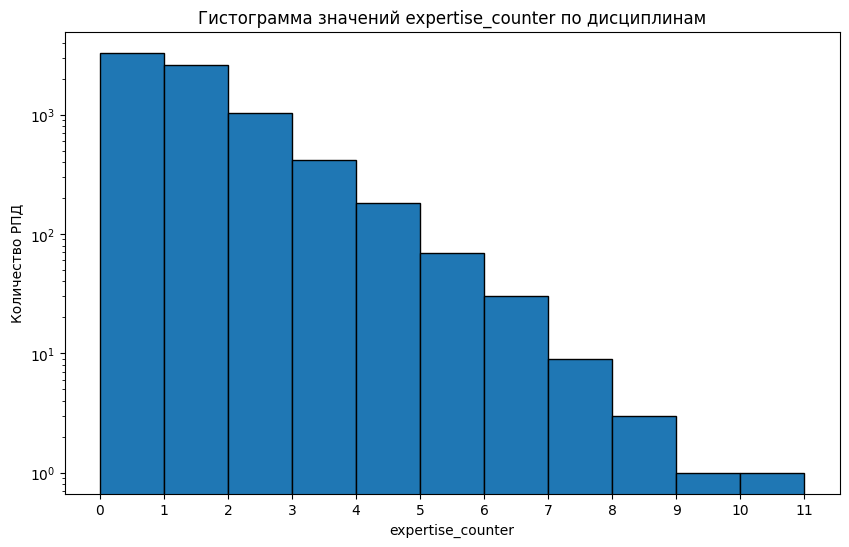

In [274]:
plt.figure(figsize=(10, 6))
plt.hist(data['expertise_counter'], bins=range(data['expertise_counter'].min(), data['expertise_counter'].max() + 2), edgecolor='black')

plt.xticks(np.arange(0, data['expertise_counter'].max() + 2, 1))
plt.yscale('log')
plt.title('Гистограмма значений expertise_counter по дисциплинам')
plt.xlabel('expertise_counter')
plt.ylabel('Количество РПД')

plt.show()

##Теперь ответьте на более интересные вопросы с использованием визуализаций.

### 1. Как распределяется количество редакторов рабочих программ на всем периоде наблюдений?

Человеческое решение.

<ipython-input-275-1afee6ceabff>:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data.groupby(data['approval_date_y'].dt.to_period('M'))['user_count'].sum().plot(kind='bar', ax=axis2)


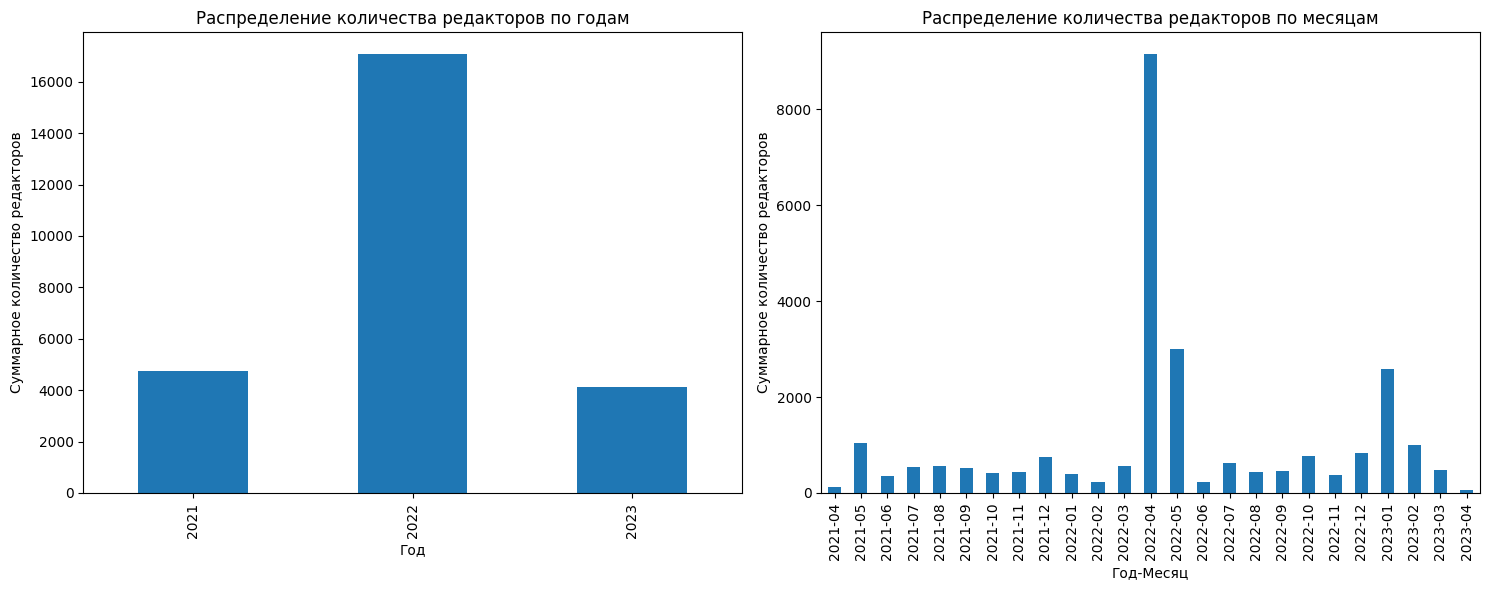

In [275]:
data['approval_date_y'] = pd.to_datetime(data['approval_date_y'], utc=True)

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 6))

data.groupby(data['approval_date_y'].dt.year)['user_count'].sum().plot(kind='bar', ax=axis1)
axis1.set_title('Распределение количества редакторов по годам')
axis1.set_xlabel('Год')
axis1.set_ylabel('Суммарное количество редакторов')

data.groupby(data['approval_date_y'].dt.to_period('M'))['user_count'].sum().plot(kind='bar', ax=axis2)
axis2.set_title('Распределение количества редакторов по месяцам')
axis2.set_xlabel('Год-Месяц')
axis2.set_ylabel('Суммарное количество редакторов')

plt.tight_layout()
plt.show()


Решение от ИИ.

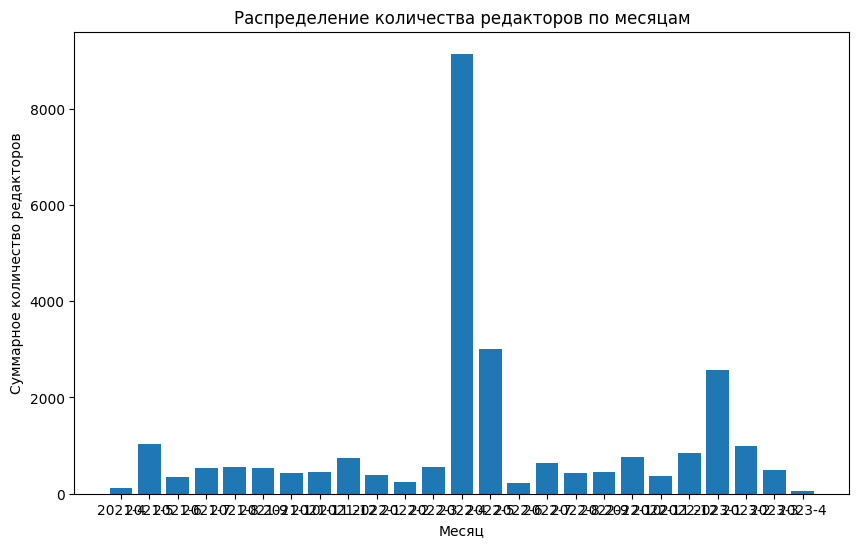

In [276]:
data['month'] = data['approval_date_y'].dt.month
data['year'] = data['approval_date_y'].dt.year

editor_distribution = {}
for _, row in data.iterrows():
    month_year = f"{row['year']}-{row['month']}"
    if month_year not in editor_distribution:
        editor_distribution[month_year] = 0
    editor_distribution[month_year] += row['user_count']

# Построение гистограммы по месяцам
plt.figure(figsize=(10, 6))
plt.bar(editor_distribution.keys(), editor_distribution.values())

plt.title('Распределение количества редакторов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Суммарное количество редакторов')

plt.show()

### 2. Как со временем менялось среднее количество экспертиз РПД?

Человеческое решение.

<ipython-input-277-28959f271232>:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  average_expertise = data.groupby(data['approval_date_y'].dt.to_period('M'))['expertise_counter'].mean()


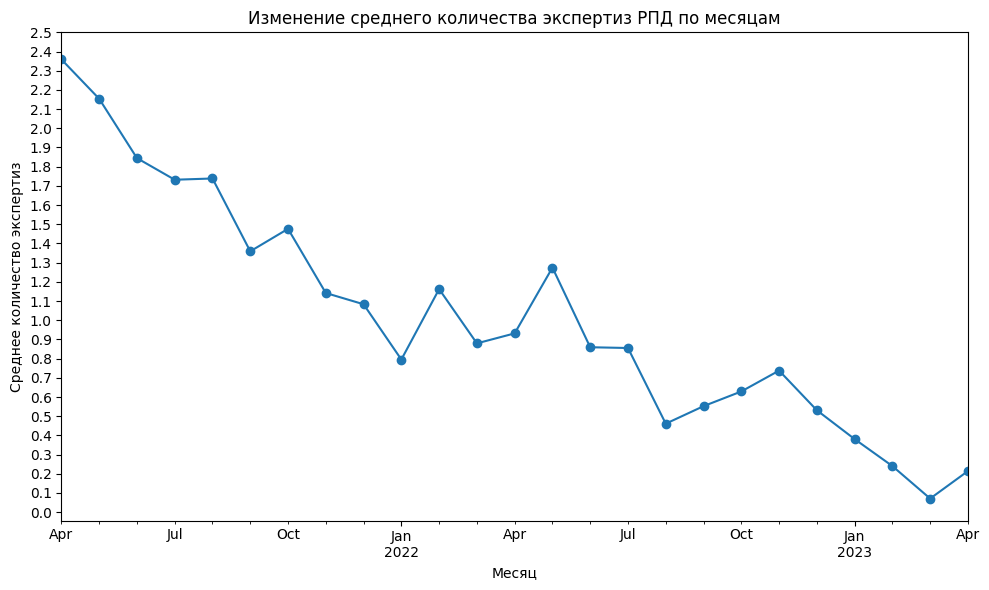

In [277]:
average_expertise = data.groupby(data['approval_date_y'].dt.to_period('M'))['expertise_counter'].mean()

plt.figure(figsize=(10, 6))
average_expertise.plot(kind='line', marker='o')
plt.title('Изменение среднего количества экспертиз РПД по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Среднее количество экспертиз')
plt.yticks(np.arange(0, 2.6, 0.1))
plt.tight_layout()
plt.show()


Решение от ИИ.

month_year
2021-04    2.358974
2021-05    2.153846
2021-06    1.844660
2021-07    1.732026
2021-08    1.738562
2021-09    1.359155
2021-10    1.476190
2021-11    1.141892
2021-12    1.083333
2022-01    0.795276
2022-02    1.162162
2022-03    0.879581
2022-04    0.931624
2022-05    1.274326
2022-06    0.859375
2022-07    0.855372
2022-08    0.461111
2022-09    0.552381
2022-10    0.628959
2022-11    0.737705
2022-12    0.531008
2023-01    0.380832
2023-02    0.240223
2023-03    0.070968
2023-04    0.214286
Freq: M, Name: expertise_counter, dtype: float64


<ipython-input-278-d6d3bfa5f0a1>:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['month_year'] = data['approval_date_y'].dt.to_period('M')


<Axes: xlabel='month_year'>

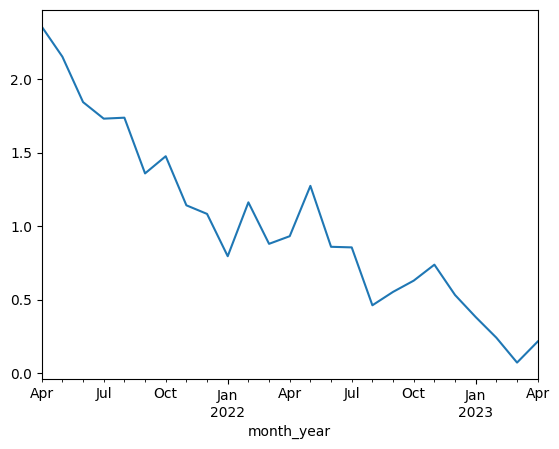

In [278]:
data['month_year'] = data['approval_date_y'].dt.to_period('M')

data['expertise_counter'] = pd.to_numeric(data['expertise_counter'], errors='coerce')

grouped = data.groupby('month_year')

monthly_avg_expertise = grouped['expertise_counter'].mean()

print(monthly_avg_expertise)

monthly_avg_expertise.plot()


### 3. Есть ли зависимость между датой и присвоением статуса "одобрено" (AC)?

Человеческое решение.

<ipython-input-279-807159695af4>:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  approval_counts = data[data['expertise_status'] == 'AC'].groupby(data['approval_date_y'].dt.to_period('M')).size().reset_index()


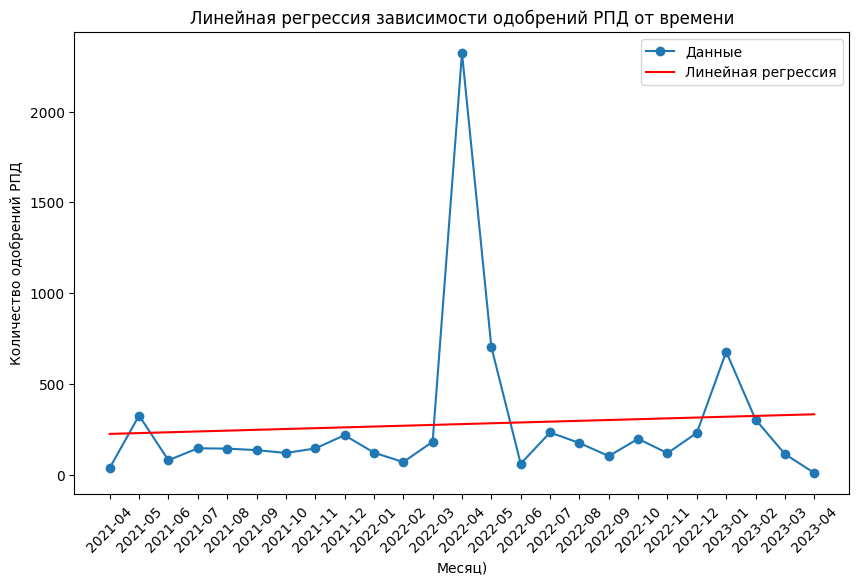

In [279]:
approval_counts = data[data['expertise_status'] == 'AC'].groupby(data['approval_date_y'].dt.to_period('M')).size().reset_index()

approval_counts['date_numeric'] = np.arange(len(approval_counts))

model = LinearRegression()
model.fit(approval_counts[['date_numeric']], approval_counts[0])

approval_counts['regression_line'] = model.predict(approval_counts[['date_numeric']])

plt.figure(figsize=(10, 6))
plt.plot(approval_counts['date_numeric'], approval_counts[0], marker='o', label='Данные')
plt.plot(approval_counts['date_numeric'], approval_counts['regression_line'], color='red', label='Линейная регрессия')
plt.title('Линейная регрессия зависимости одобрений РПД от времени')
plt.xlabel('Месяц)')
plt.ylabel('Количество одобрений РПД')
plt.xticks(approval_counts['date_numeric'], approval_counts['approval_date_y'].dt.strftime('%Y-%m'), rotation=45)
plt.legend()
plt.show()

Решение от ИИ.

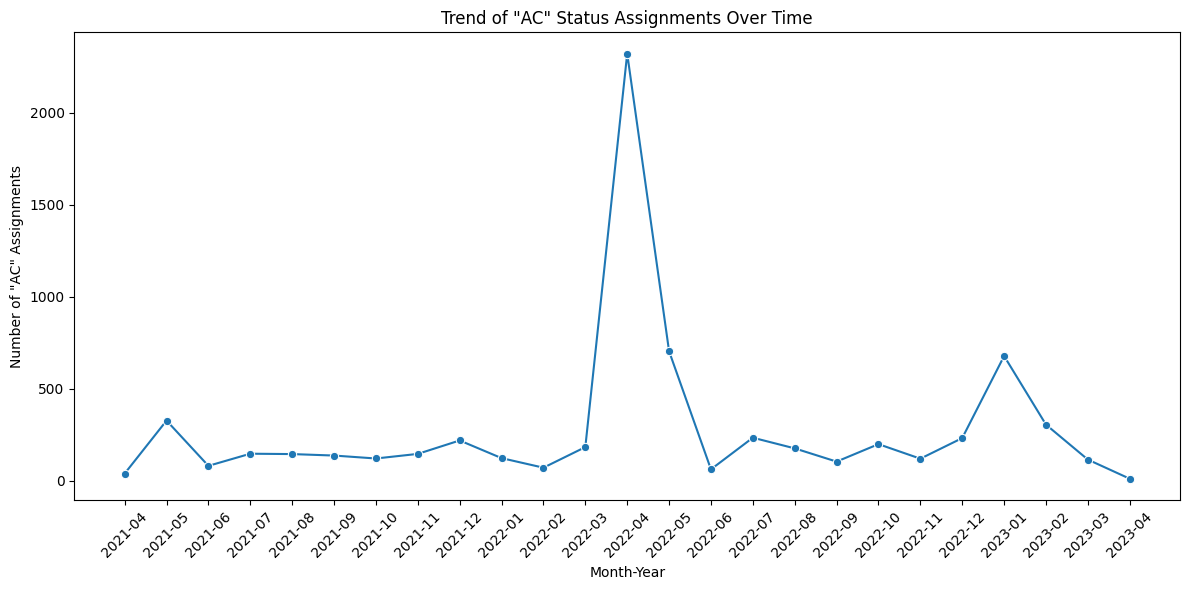

In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is the DataFrame with the dataset
data['approval_date_y'] = pd.to_datetime(data['approval_date_y']).dt.tz_localize(None)  # Remove timezone

# Filter data for rows where expertise_status is 'AC'
ac_data = data[data['expertise_status'] == 'AC'].copy()  # Ensure to use .copy() to avoid SettingWithCopyWarning

# Create a new column to extract the month and year from the approval_date_y
ac_data['approval_month_year'] = ac_data['approval_date_y'].dt.to_period('M')

# Convert the 'approval_month_year' to string for plotting
ac_data['approval_month_year_str'] = ac_data['approval_month_year'].astype(str)

# Group by the month-year and count the occurrences of AC status
ac_counts_by_month = ac_data.groupby('approval_month_year_str').size().reset_index(name='count')

# Plot the data to visualize the trend over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=ac_counts_by_month, x='approval_month_year_str', y='count', marker='o')
plt.title('Trend of "AC" Status Assignments Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Number of "AC" Assignments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Оцените результаты

Была проведена работа по анализу данных самостоятельно и используя ИИ. Как мы можем наблюдать, ИИ справился с задачами, но заметны шероховатости, как то наезжающие друг на друга буквы на графиках или неоптимизированное решение. При самостоятельной работе же таких проблем нет, они легко решаются. Также следует заметить, что даже с такими не самыми сложными задачами ИИ справляется с трудом: несколько раз он выдавал совсем не то, что нужно. Подытоживая, скажу, что хоть "искусственный интеллект" и кажется решением всех проблем, на деле это не более чем инструмент, который ещё дорабатывать и дорабатывать.